## Install Libs

In [ ]:
%pip install -r requirements.txt
%pip install .

## Train

In [2]:
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from g2rl import G2RLAgent, G2RLEnv
from g2rl import DDQNAgent, CRNNModel, moving_cost, detour_percentage, train

In [ ]:
device = 'cuda'
map_settings = {
    'regular_1': {
        'size': 50,
        'density': 0.392,
        'num_agents': 4,
    },
    'regular_2': {
        'size': 50,
        'density': 0.452,
        'num_agents': 6,
    },
    'random_1': {
        'size': 50,
        'density': 0.15,
        'num_agents': 6,
    },
    'random_2': {
        'size': 50,
        'density': 0.25,
        'num_agents': 7,
    },
    'free_1': {
        'size': 50,
        'density': 0,
        'num_agents': 11,
    },
    'free_2': {
        'size': 50,
        'density': 0.1,
        'num_agents': 15,
    },
}
map_probs = [1, 1, 1, 1, 1, 1]
model = CRNNModel(lstm_input_size=1024)
# model.load_state_dict(torch.load('models/16-07-24-05-2024.pt', map_location=device))

<All keys matched successfully>

In [ ]:
trained_agent = train(
    model,
    map_settings=map_settings,
    map_probs=map_probs,
    num_episodes=500,
    batch_size=32,
    replay_buffer_size=500,
    decay_range=5_000,
    log_dir='logs',
    device=device,
)

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
torch.save(trained_agent.target_network.state_dict(), 'models/latest_model.pt')

In [ ]:
trained_agent.target_network

CRNNModel(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv3d(4, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (1): ReLU()
      (2): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (1): ReLU()
      (2): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
      (3): ReLU()
    )
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (lstm): LSTM(1024, 128, batch_first=True)
)

## Test

### Basic performance

In [ ]:
from IPython.display import SVG, display

In [ ]:
device = 'cpu'
map_settings = {
    'regular': {
        'size': 48,
        'density': 0.392,
        'num_agents': 4,
    },
    'random': {
        'size': 48,
        'density': 0.15,
        'num_agents': 6,
    },
    'free': {
        'size': 48,
        'density': 0,
        'num_agents': 11,
    },
    'test': {
        'size': 48,
        'density': 0.1,
        'num_agents': 5,
    }
}

In [ ]:
env = G2RLEnv(**map_settings['test'], max_episode_steps=60)
model = CRNNModel(lstm_input_size=1024)
model.load_state_dict(torch.load('models/20-42-22-05-2024.pt', map_location=device))

agent = G2RLAgent(
    model,
    action_space=env.get_action_space(),
    epsilon=0,
    device=device)

In [ ]:
obs, info = env.reset()
terminated = truncated = [False, ...]
hist = []
rhist = []

while not all(terminated) and not all(truncated):
    actions = [agent.act(ob) for ob in obs]
    obs, reward, terminated, truncated, info = env.step(actions)
    hist.append(obs[3]['view_cache'][-1,:,:,-1])
    rhist.append(reward[3])

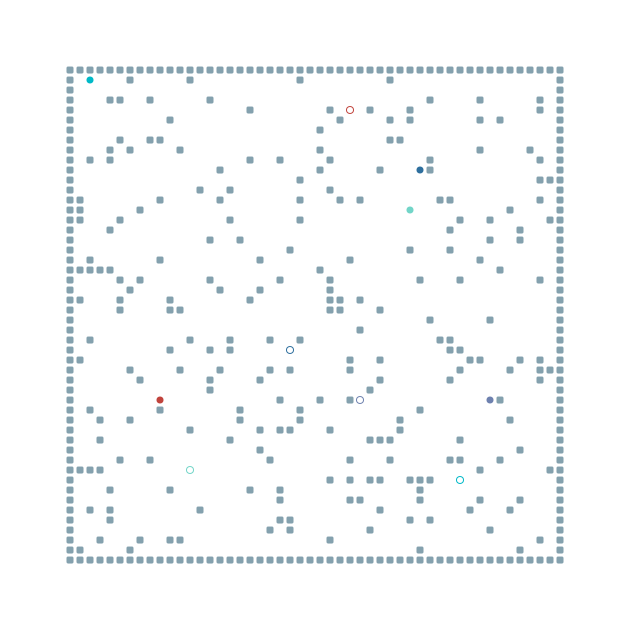

In [ ]:
env.save_animation('renders/test.svg')
display(SVG('renders/test.svg'))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### Default Maps

In [ ]:
from PIL import Image
import pandas as pd

In [ ]:
def image2grid(image_path: str) -> np.ndarray:
    image = Image.open(image_path).convert('L')
    threshold_value = 128
    binary_image = np.array(image) < threshold_value
    return list(binary_image.astype(int))


def test(env, agent, name: str = "") -> tuple[list, list, dict]:
    obs, info = env.reset()
    opt_paths = [[(ob['global_xy'])] + path for path, ob in zip(env.global_guidance, obs)]
    start = [[path[0][0] - env.obs_radius, path[0][1] - env.obs_radius] for path in opt_paths]
    finish = [[path[-1][0] - env.obs_radius, path[-1][1] - env.obs_radius] for path in opt_paths]
    terminated = truncated = [False, ...]
    timesteps = [0] * len(obs)
    scalars = {
        'moving_cost': [],
        'detour_percentage': [],
        'done': 0,
    }

    latest_obs = obs
    latest_info = info
    while not all(terminated) and not all(truncated):
        timesteps = [t + 1 for t in timesteps]
        actions = [agent.act(ob) if status['is_active'] else 0 for ob, status in zip(obs, info)]
        obs, reward, terminated, truncated, info = env.step(actions)
        for i in range(env.num_agents):
            if obs[i]['global_xy'] == latest_obs[i]['global_target_xy']:
                if (latest_info[i]['is_active'] and not info[i]['is_active']) or info[i]['is_active']:
                    if obs[i]['global_xy'] != latest_obs[i]['global_xy']:
                        scalars['moving_cost'].append(moving_cost(timesteps[i], opt_paths[i][0], opt_paths[i][-1]))
                        scalars['detour_percentage'].append(detour_percentage(timesteps[i], len(opt_paths[i]) - 1))
                        scalars['done'] += 1
                        if info[i]['is_active'] and obs[i]['global_xy'] != obs[i]['global_target_xy']:
                            opt_paths[i] = [obs[i]['global_xy']] + env.global_guidance[i]
                            timesteps[i] = 0
        latest_obs = obs
        latest_info = info

    env.save_animation(f'renders/{name}.svg')

    n = len(scalars['moving_cost'])
    scalars['moving_cost'] = sum(scalars['moving_cost']) / n if n > 0 else 0
    scalars['detour_percentage'] = sum(scalars['detour_percentage']) / n if n > 0 else 0
    return start, finish, scalars

In [ ]:
default_map_settings = {
    'random': {
        'size': 48,
        'num_agents': None,
        'density': None,
        'map': image2grid('data/empty-48-48-random-10_60_agents.png'),

    },
    'even': {
        'size': 48,
        'num_agents': None,
        'density': None,
        'map': image2grid('data/empty-48-48-even-10_60_agents.png'),
    }
}

In [ ]:
agent = G2RLAgent(
    model,
    action_space=5,
    epsilon=0,
    device=device)

results = {
    'map': [],
    'num_agents': [],
    'max_steps': [],
    'density': [],
    'size': [],
    'start': [],
    'final': [],
    'done': [],
    'detour_percentage': [],
    'moving_cost': [],
}

for map_name, map_value in default_map_settings.items():
    for num_agents in [3, 6, 12]:
        map_value['num_agents'] = num_agents
        for steps in [60, 120, 180]:
            env = G2RLEnv(**map_value, max_episode_steps=steps, on_target='finish')
            start, finish, scalars = test(env, agent, name=f'{map_name}_{num_agents}_{steps}')
            results['map'].append(map_name)
            results['num_agents'].append(num_agents)
            results['max_steps'].append(steps)
            results['done'].append(scalars['done'])
            results['detour_percentage'].append(scalars['detour_percentage'])
            results['moving_cost'].append(scalars['moving_cost'])
            results['start'].append(start)
            results['final'].append(finish)
            results['density'].append(map_value['density'])
            results['size'].append(map_value['size'])

stat = pd.DataFrame(data=results)

In [ ]:
stat

,map,num_agents,max_steps,density,size,start,final,done,detour_percentage,moving_cost
0,random,3,60,None,48,"[[25, 22], [17, 13], [22, 39]]","[[28, 26], [32, 16], [46, 32]]",2,0.000000,1.120072
1,random,3,120,None,48,"[[25, 22], [17, 13], [22, 39]]","[[28, 26], [32, 16], [46, 32]]",2,0.000000,1.120072
2,random,3,180,None,48,"[[25, 22], [17, 13], [22, 39]]","[[28, 26], [32, 16], [46, 32]]",2,0.000000,1.120072
3,random,6,60,None,48,"[[25, 22], [17, 13], [22, 39], [32, 36], [38, ...","[[28, 26], [32, 16], [46, 32], [28, 19], [33, ...",5,0.000000,1.141997
4,random,6,120,None,48,"[[25, 22], [17, 13], [22, 39], [32, 36], [38, ...","[[28, 26], [32, 16], [46, 32], [28, 19], [33, ...",5,0.000000,1.141997
5,random,6,180,None,48,"[[25, 22], [17, 13], [22, 39], [32, 36], [38, ...","[[28, 26], [32, 16], [46, 32], [28, 19], [33, ...",5,0.000000,1.141997
6,random,12,60,None,48,"[[25, 22], [17, 13], [22, 39], [32, 36], [38, ...","[[28, 26], [32, 16], [46, 32], [28, 19], [33, ...",9,1.915709,1.137863
7,random,12,120,None,48,"[[25, 22], [17, 13], [22, 39], [32, 36], [38, ...","[[28, 26], [32, 16], [46, 32], [28, 19], [33, ...",9,1.915709,1.137863
8,random,12,180,None,48,"[[25, 22], [17, 13], [22, 39], [32, 36], [38, ...","[[28, 26], [32, 16], [46, 32], [28, 19], [33, ...",9,1.915709,1.137863
9,even,3,60,None,48,"[[32, 25], [46, 10], [12, 4]]","[[6, 41], [45, 11], [28, 32]]",2,0.000000,1.000000


In [ ]:
stat.to_csv('data/default_statistics.csv', index=False)

### Different env modes

In [ ]:
on_target_ops = ['restart', 'finish', 'nothing']
collission_system_ops = ['priority', 'block_both', 'soft']

In [ ]:
for on_target in on_target_ops:
    for collission_system in collission_system_ops:
        env = G2RLEnv(
            **map_settings['free'],
            max_episode_steps=60,
            on_target=on_target,
            collission_system=collission_system)
        agent = G2RLAgent(
            model,
            action_space=5,
            epsilon=0,
            device=device,
            lifelong=on_target == 'restart')
        result = test(env, agent, name=f'free_{on_target}_{collission_system}')

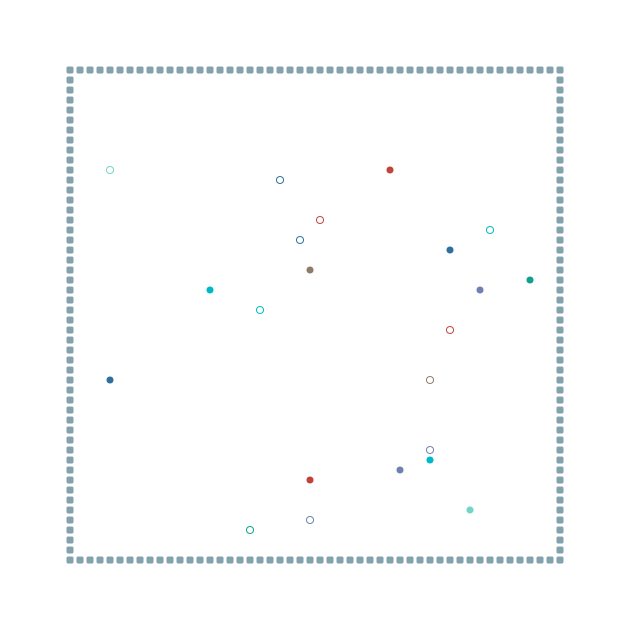

In [ ]:
display(SVG(f'renders/free_nothing_soft.svg'))